<a href="https://colab.research.google.com/github/MaikarfiJesse/Housing_model_ML/blob/main/Copy_of_NN_housing_model_Jesse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRJECT NAME: Housep**

## Built by:

1. **J.maikarfi1@alustudent.com**

# Case Study and Implementation

Case Study Summary: House Data Classification


# The Dataset
**Short Description of the Data:**

The dataset has a shape of (24326, 8) which is 24326 rows and 8 columns. The columns include bedrooms	bathrooms	toilets	parking_space	title	town	state	price. While manipulating the dataset I removed some less important columns like title, town & state before training the model. The task is to develop a model that can learn and generalize from this data to accurately tell expected price of houses in Lagos.

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from sklearn.compose import ColumnTransformer


Connect Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Data Processing

In [ ]:
path = '/content/drive/MyDrive/nigeria_houses_data.csv'
df = pd.read_csv(path, sep=',')
print(df.shape)
df.head()


(24326, 8)


,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
1,4.0,5.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,800000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Test data

In [ ]:
# df.tail()

# df.columns

df.isnull().sum()

# df.info()

# df.describe()

bedrooms         0
bathrooms        0
toilets          0
parking_space    0
title            0
town             0
state            0
price            0
dtype: int64

### Create Lagos dataframe and check for outliers

   bedrooms  bathrooms  toilets  parking_space                 title   town  \
2       4.0        5.0      5.0            4.0       Detached Duplex  Lekki   
3       4.0        4.0      5.0            6.0       Detached Duplex   Ajah   
4       4.0        4.0      5.0            2.0  Semi Detached Duplex  Lekki   
5       5.0        5.0      6.0            1.0       Detached Duplex  Lekki   

   state        price  
2  Lagos  120000000.0  
3  Lagos   40000000.0  
4  Lagos   75000000.0  
5  Lagos  450000000.0  
120.0


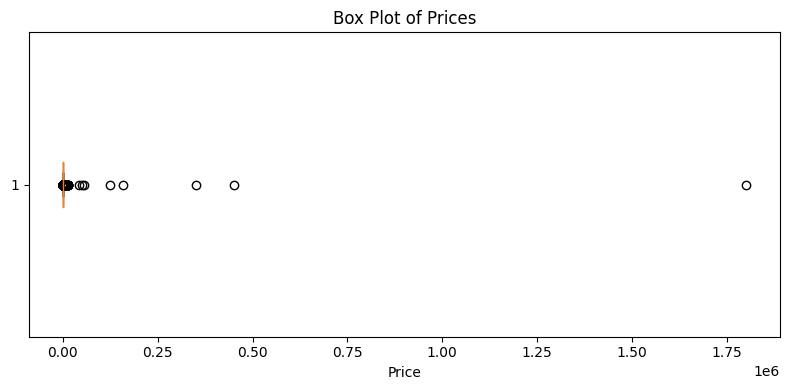

In [ ]:
# Filter the dataset to include only rows where the 'state' column is 'Lagos'
lagos_df = df[df['state'] == 'Lagos']

# print(lagos_df.shape)
# lagos_df.head()
print(lagos_df[:4])

# Draw a visualization of price values
values = lagos_df['price'].values
prices=[]
for price in values:
  price *=0.000001
  prices.append(price)
print(prices[0])

# Plotting the box plot
plt.figure(figsize=(8, 4))
plt.boxplot(prices, vert=False, patch_artist=True)
plt.title('Box Plot of Prices')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

### Remove Outliers

120000.0


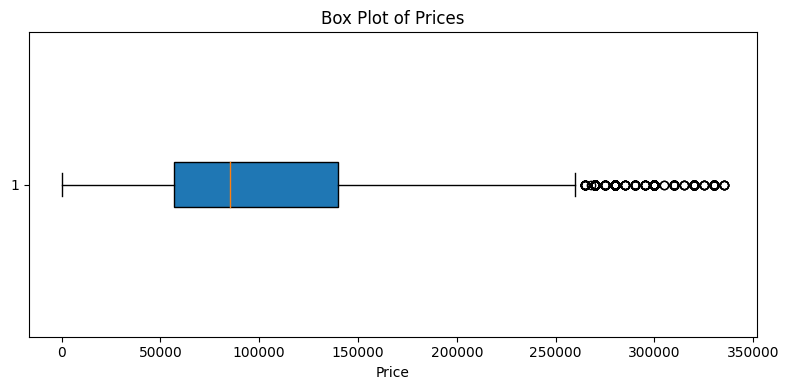

In [ ]:
# Assuming df is your DataFrame and 'price' is the column with outliers
Q1 = lagos_df['price'].quantile(0.25)
Q3 = lagos_df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those that are below (Q1 - 1.5 * IQR) or above (Q3 + 1.5 * IQR)
outliers = (lagos_df['price'] < (Q1 - 1.5 * IQR)) | (lagos_df['price'] > (Q3 + 1.5 * IQR))

# Remove outliers from the DataFrame
df_no_outliers = lagos_df[~outliers]

# Draw a visualization of price values
values = df_no_outliers['price'].values
prices=[]
for price in values:
  price *=0.001
  prices.append(price)
print(prices[0])

# Plotting the box plot
plt.figure(figsize=(8, 4))
plt.boxplot(prices, vert=False, patch_artist=True)
plt.title('Box Plot of Prices')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

# Model Implementation

## 1. Without Regularization


### Split dataset to train, test and validation sets

In [ ]:
# Dropping unused categorical features
df_encoded = df_no_outliers.drop(['title', 'town', 'state'], axis=1)

# Separate features and target from the filtered dataset
X = df_encoded.drop('price', axis=1)
print(X.columns)
y = df_encoded['price']

# Preprocessing
numeric_features = ['bedrooms', 'bathrooms', 'toilets', 'parking_space']
numeric_transformer = StandardScaler()

# # Assuming 'title', 'town', 'state' are the categorical features you initially intended to encode
categorical_features = ['title', 'town', 'state']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split X_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Adjust the input shape based on the preprocessed data
input_shape = [X_train_preprocessed.shape[1]]
print(input_shape)
print(X_train.shape)


Index(['bedrooms', 'bathrooms', 'toilets', 'parking_space'], dtype='object')
[4]
(9906, 4)


### 1. Model Architecture

Layers:

    Input Dense Layer (500 Neurons). It has 500 neurons & applies a ReLU (Rectified Linear Unit) activation function.

    Dense Layer with (256 Neurons) & applies the ReLU activation function.

    Dense Layer with (128 Neurons) & applies the ReLU activation function.

    Dense Layer with (64 Neurons) & applies the ReLU activation function.

    Dense Layer (32 Neurons) & ReLU activation function for non-linearity.

    Dense Layer with (16 Neurons) & applies the ReLU activation function.

    Dense Layer with (8 Neurons) & applies the ReLU activation function.

    Output Dense Layer (1 Neuron).


### 2. Model Training

In [ ]:
# Create the model
model = Sequential([
    Dense(500, activation='relu', input_shape=input_shape),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mean_squared_error',
              metrics=[MeanSquaredError(), MeanAbsoluteError()])

model.summary()

# Train the model
train_model=model.fit(X_train_preprocessed, y_train,
          validation_data=(X_val_preprocessed, y_val),
          epochs=100,
          batch_size=64)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 500)               2500      
                                                                 
 dense_9 (Dense)             (None, 256)               128256    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 8)                

In [ ]:
# Create the model
l2_model = Sequential([
    Dense(500, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(1)
])

l2_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mean_squared_error',
              metrics=[MeanSquaredError(), MeanAbsoluteError()])

l2_model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# Train the model
train_model=l2_model.fit(X_train_preprocessed, y_train,
          validation_data=(X_val_preprocessed, y_val),
          epochs=100,
          batch_size=42,
          callbacks=[es])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 500)               2500      
                                                                 
 dense_17 (Dense)            (None, 256)               128256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 32)               

### Print Test results. MSE & MAE

In [ ]:
# Evaluate the model
test_metrics = model.evaluate(X_test_preprocessed, y_test)
print(test_metrics)
print(f"Test MSE: {test_metrics[1]}")
print(f"Test MAE: {test_metrics[2]}")

104/104 [==============================] - 0s 2ms/step - loss: 3737535838683136.0000 - mean_squared_error: 3737535838683136.0000 - mean_absolute_error: 44458360.0000
[3737535838683136.0, 3737535838683136.0, 44458360.0]
Test MSE: 3737535838683136.0
Test MAE: 44458360.0


In [ ]:
# Evaluate the model
test_metrics = l2_model.evaluate(X_test_preprocessed, y_test)
print(test_metrics)
print(f"Test MSE: {test_metrics[1]}")
print(f"Test MAE: {test_metrics[2]}")

104/104 [==============================] - 0s 3ms/step - loss: 3849587240468480.0000 - mean_squared_error: 3849587240468480.0000 - mean_absolute_error: 43430792.0000
[3849587240468480.0, 3849587240468480.0, 43430792.0]
Test MSE: 3849587240468480.0
Test MAE: 43430792.0


### Check mean Price of the trained model

In [ ]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean price:", y_mean)
print("Baseline MSE:", mean_squared_error(y_train, y_pred_baseline))

Mean price: 107362925.04613365
Baseline MSE: 5331835914009688.0


# Make Predictions

In [ ]:
# scaler = StandardScaler()
scaler = StandardScaler().fit(X_train)

def make_prediction(bedrooms, bathrooms, toilets, parking_space ):

    data = {"bedrooms":bedrooms,
            "bathrooms":bathrooms,
            "toilets":toilets,
            "parking_space": parking_space
    }
    # Convert new_data to DataFrame
    data_df = pd.DataFrame([data])
    data_encoded_df = pd.get_dummies(data_df)
    new_data_scaled = scaler.transform(data_encoded_df)

    predicted_price = model.predict(new_data_scaled)
    # print(predicted_price)
    print(f'Predicted Price: ₦{predicted_price[0][0]}')


make_prediction(4, 5, 5, 4) ## expected ₦120M got ₦91,402,832
make_prediction(4, 4, 5, 6) ## expected ₦120M got ₦97,701,544
make_prediction(4, 4, 5, 2) ## expected ₦75M got ₦91,072,488
make_prediction(5, 5, 6, 1) ## expected ₦450M got ₦140,743,104


1/1 [==============================] - 0s 96ms/step
Predicted Price: ₦92898584.0
1/1 [==============================] - 0s 18ms/step
Predicted Price: ₦108757528.0
1/1 [==============================] - 0s 15ms/step
Predicted Price: ₦83093488.0
1/1 [==============================] - 0s 15ms/step
Predicted Price: ₦116456400.0


In [ ]:
# scaler = StandardScaler()
scaler = StandardScaler().fit(X_train)

def make_prediction(bedrooms, bathrooms, toilets, parking_space ):

    data = {"bedrooms":bedrooms,
            "bathrooms":bathrooms,
            "toilets":toilets,
            "parking_space": parking_space
    }
    # Convert new_data to DataFrame
    data_df = pd.DataFrame([data])
    data_encoded_df = pd.get_dummies(data_df)
    new_data_scaled = scaler.transform(data_encoded_df)

    predicted_price = l2_model.predict(new_data_scaled)
    # print(predicted_price)
    print(f'Predicted Price: ₦{predicted_price[0][0]}')


make_prediction(4, 5, 5, 4) ## expected ₦120M got ₦92,844,680
make_prediction(4, 4, 5, 6) ## expected ₦120M got ₦110,647,232
make_prediction(4, 4, 5, 2) ## expected ₦75M got ₦82,775,976
make_prediction(5, 5, 6, 1) ## expected ₦450M got ₦112,023,232


1/1 [==============================] - 0s 70ms/step
Predicted Price: ₦86616912.0
1/1 [==============================] - 0s 17ms/step
Predicted Price: ₦96591232.0
1/1 [==============================] - 0s 15ms/step
Predicted Price: ₦73518248.0
1/1 [==============================] - 0s 15ms/step
Predicted Price: ₦109454136.0
